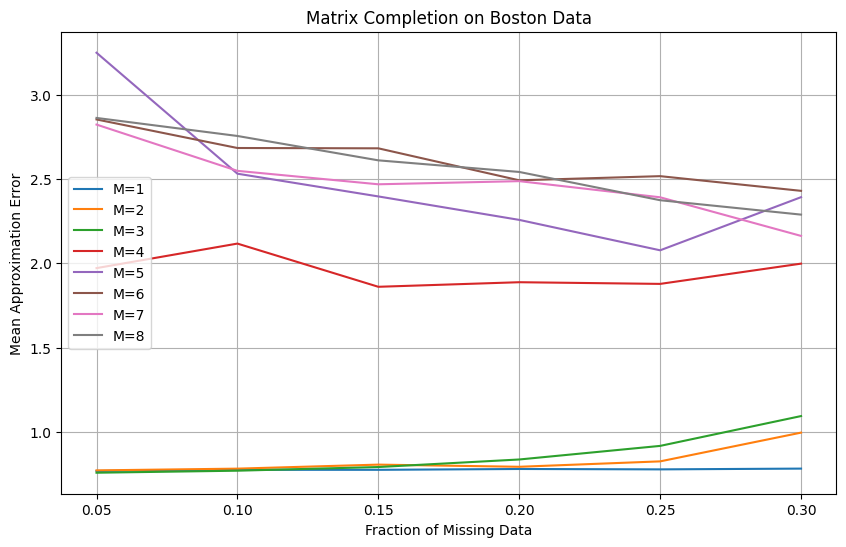

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

boston = pd.read_csv("../../data/Boston.csv").rename({"Unnamed: 0": "Id"}, axis=1).set_index("Id")

X = boston.drop(columns=['medv'], errors='ignore').values  # convert to NumPy array

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def simulate_missing_data(X, missing_fraction):
    X_missing = X.copy()
    n_samples, n_features = X.shape
    n_missing = int(np.floor(missing_fraction * n_samples * n_features))
    missing_indices = np.random.choice(n_samples * n_features, n_missing, replace=False)
    X_missing.ravel()[missing_indices] = np.nan
    return X_missing, missing_indices

def matrix_completion(X, rank=5, tol=1e-5, max_iter=1000, verbose=False):
    missing_mask = np.isnan(X)
    X_filled = X.copy()
    col_mean = np.nanmean(X_filled, axis=0)
    inds = np.where(missing_mask)
    X_filled[inds] = np.take(col_mean, inds[1])
    
    errors = []
    for i in range(max_iter):
        U, s, Vt = np.linalg.svd(X_filled, full_matrices=False)
        s[rank:] = 0
        X_new = (U * s) @ Vt
        X_filled[missing_mask] = X_new[missing_mask]
        
        rel_error = np.linalg.norm(X_new - X_filled, ord='fro') / np.linalg.norm(X_filled, ord='fro')
        errors.append(rel_error)
        
        if rel_error < tol:
            break
    return X_filled, errors

missing_fractions = np.arange(0.05, 0.35, 0.05)
ranks = np.arange(1, 9)
n_repeats = 10

mean_errors = np.zeros((len(missing_fractions), len(ranks)))

for i, frac in enumerate(missing_fractions):
    for j, rank in enumerate(ranks):
        errors = []
        for _ in range(n_repeats):
            X_missing, missing_indices = simulate_missing_data(X_scaled, frac)
            X_completed, _ = matrix_completion(X_missing, rank=rank)
            true_values = X_scaled.ravel()[missing_indices]
            completed_values = X_completed.ravel()[missing_indices]
            error = np.linalg.norm(true_values - completed_values) / np.linalg.norm(true_values)
            errors.append(error)
        mean_errors[i, j] = np.mean(errors)

plt.figure(figsize=(10, 6))
for j, rank in enumerate(ranks):
    plt.plot(missing_fractions, mean_errors[:, j], label=f'M={rank}')
plt.xlabel('Fraction of Missing Data')
plt.ylabel('Mean Approximation Error')
plt.title('Matrix Completion on Boston Data')
plt.legend()
plt.grid(True)
plt.show()

From the plot, a few patterns emerge. First, lower-rank approximations (e.g., $M = 1, 2, 3$) generally have lower approximation errors at smaller fractions of missing data but tend to increase slightly as more data is missing. This is because a very low-rank approximation may capture the main structure of the data efficiently when the missing fraction is low, but it lacks flexibility to approximate more complex patterns when more entries are missing. Conversely, higher ranks (e.g., $M = 5, 6, 7, 8$) show higher initial errors but decrease as the missing fraction increases. This may reflect overfitting to the observed entries in early iterations, which smooths out as more data is left out in a controlled experiment.

Interestingly, the middle-range ranks (around $M = 4, 5$) appear to achieve a balance: they are flexible enough to capture relevant structure without overfitting noise, resulting in relatively stable errors across different missing fractions. This behavior aligns with the general understanding of matrix completion: choosing an appropriate rank is crucial. Too small a rank may underfit, failing to capture meaningful variation in the data, while too high a rank can overfit to the observed entries and amplify errors when estimating missing values.

Overall, the plot highlights how the **interaction between the missing data fraction and the chosen rank** affects reconstruction accuracy. It provides a clear visual guide for selecting a reasonable rank $M$ when performing matrix completion: middle-range ranks often provide the best trade-off between capturing structure and avoiding overfitting, especially as the fraction of missing data increases.